# Predicting the overall ratings
Adam Jordan

## Intent

1. Use data from FIFA 19. Predict the Overall (OVR) skill Statistic for players in the FIFA 20 Edition. Train on all players from FIFA 19. Graphically represent the Overall data for the players in the Test Set.
2. How do each of the different attributes affect the Overall Score of a player? Are some more weighted than others?
3. What are the attributes of those with the highest ratings?
4. How have those skill attributes changed in significance over the last few games?


In [1]:
# imports & setup
import pandas as pd
import sklearn as sk
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
import numpy as np
import re
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

## Importing the Data

This pulls the necessary training and test data for initial work. This is based upon the player_data_cleaning notebook, which outputs these modified data files.

In [2]:
# import the cleaned data for FIFA19
p19_df = pd.read_csv('cleaned_data/players_19.csv')
display(p19_df.head())

/Users/xylamic/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,...,player_positions_gk,player_positions_cdm,player_positions_rm,player_positions_lm,player_positions_cm,player_positions_lw,player_positions_lb,player_positions_rb,player_positions_lwb,preferred_foot_bin
0,0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,...,0,0,0,0,0,1,0,0,0,0
1,1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,...,0,0,0,0,0,0,0,0,0,1
2,2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,...,0,0,0,0,0,1,0,0,0,0
3,3,193080,https://sofifa.com/player/193080/david-de-gea-...,De Gea,David De Gea Quintana,27,1990-11-07,193,76,Spain,...,1,0,0,0,0,0,0,0,0,0
4,4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,27,1991-06-28,181,70,Belgium,...,0,0,0,0,1,0,0,0,0,0


In [3]:
# import the cleaned data for FIFA20
p20_df = pd.read_csv('cleaned_data/players_20.csv')
display(p20_df.head())

,Unnamed: 0,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,...,player_positions_gk,player_positions_cdm,player_positions_rm,player_positions_lm,player_positions_cm,player_positions_lw,player_positions_lb,player_positions_rb,player_positions_lwb,preferred_foot_bin
0,0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,...,0,0,0,0,0,0,0,0,0,1
1,1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,...,0,0,0,0,0,1,0,0,0,0
2,2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,...,0,0,0,0,0,1,0,0,0,0
3,3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,...,1,0,0,0,0,0,0,0,0,0
4,4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,...,0,0,0,0,0,1,0,0,0,0


In [4]:
# get list of columns for predictions
target_cols = []
with open('cleaned_data/player_data_cols.csv') as cols_file:
    for col in cols_file:
        col = col.replace('\n', '')
        target_cols.append(col)

In [5]:
p19_df.columns

Index(['Unnamed: 0', 'sofifa_id', 'player_url', 'short_name', 'long_name',
       'age', 'dob', 'height_cm', 'weight_kg', 'nationality',
       ...
       'player_positions_gk', 'player_positions_cdm', 'player_positions_rm',
       'player_positions_lm', 'player_positions_cm', 'player_positions_lw',
       'player_positions_lb', 'player_positions_rb', 'player_positions_lwb',
       'preferred_foot_bin'],
      dtype='object', length=150)

In [6]:
# setup train & test sets
x_train = p19_df[target_cols]
y_train = p19_df['overall']

x_test = p20_df[target_cols]
y_test = p20_df['overall']

## Review the data

This section will include any needed analysis of the data set, prior to working with it.

In [7]:
x_train.describe()

,team_position_rm,attacking_crossing,movement_balance,team_position_rf,mentality_vision,lb,goalkeeping_diving,player_positions_lm,cf,team_position_rs,...,preferred_foot_bin,goalkeeping_reflexes,power_stamina,team_position_rwb,ldm,rb,player_positions_cdm,skill_long_passing,st,team_position_cm
count,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,...,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000
mean,0.024734,49.657662,63.914173,0.000570,53.327520,50.367128,16.695219,0.143956,52.104861,0.010885,...,0.232860,16.794153,63.095401,0.002109,50.386562,50.367128,0.149712,52.611615,51.318630,0.003533
std,0.155316,18.395042,14.179044,0.023866,14.158393,19.986492,17.786806,0.351055,20.672274,0.103765,...,0.422666,18.041419,15.968770,0.045873,20.238055,19.986492,0.356799,15.371942,20.126557,0.059339
min,0.000000,5.000000,16.000000,0.000000,10.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,12.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000
25%,0.000000,38.000000,56.000000,0.000000,44.000000,46.000000,8.000000,0.000000,48.000000,0.000000,...,0.000000,8.000000,56.000000,0.000000,46.000000,46.000000,0.000000,42.000000,48.000000,0.000000
50%,0.000000,54.000000,66.000000,0.000000,55.000000,56.000000,11.000000,0.000000,58.000000,0.000000,...,0.000000,11.000000,66.000000,0.000000,56.000000,56.000000,0.000000,56.000000,57.000000,0.000000
75%,0.000000,64.000000,74.000000,0.000000,64.000000,63.000000,14.000000,0.000000,65.000000,0.000000,...,0.000000,14.000000,74.000000,0.000000,63.000000,63.000000,0.000000,64.000000,64.000000,0.000000
max,1.000000,93.000000,99.000000,1.000000,94.000000,85.000000,91.000000,1.000000,93.000000,1.000000,...,1.000000,94.000000,96.000000,1.000000,87.000000,85.000000,1.000000,93.000000,91.000000,1.000000


In [8]:
y_train.describe()

count    17547.000000
mean        66.224540
std          7.010663
min         47.000000
25%         62.000000
50%         66.000000
75%         71.000000
max         94.000000
Name: overall, dtype: float64

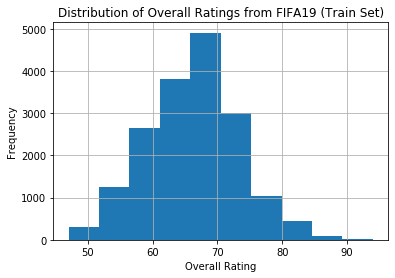

In [9]:
y_train.hist(bins=10)
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Ratings from FIFA19 (Train Set)')
plt.show()

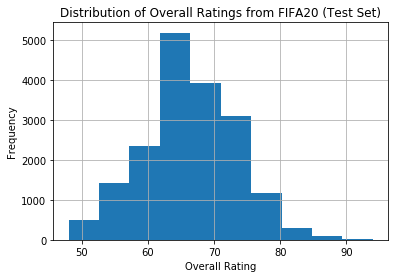

In [10]:
y_test.hist(bins=10)
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Ratings from FIFA20 (Test Set)')
plt.show()

In [11]:
import math

corr_matrix = x_train.corr()
for row_num in range(math.ceil(corr_matrix.shape[0] / 2)):
    for col_num in range(corr_matrix.shape[1]):
        if corr_matrix.iloc[row_num, col_num] > 0.95 and row_num != col_num:
            print(f'Value above found at {corr_matrix.index[row_num]}/{corr_matrix.columns[col_num]}.')

Value above found at lb/lwb.
Value above found at lb/cb.
Value above found at lb/rwb.
Value above found at lb/lcb.
Value above found at lb/rcb.
Value above found at lb/rdm.
Value above found at lb/cdm.
Value above found at lb/ldm.
Value above found at lb/rb.
Value above found at goalkeeping_diving/gk_positioning.
Value above found at goalkeeping_diving/goalkeeping_kicking.
Value above found at goalkeeping_diving/gk_handling.
Value above found at goalkeeping_diving/gk_diving.
Value above found at goalkeeping_diving/goalkeeping_positioning.
Value above found at goalkeeping_diving/gk_reflexes.
Value above found at goalkeeping_diving/goalkeeping_handling.
Value above found at goalkeeping_diving/player_positions_gk.
Value above found at goalkeeping_diving/gk_kicking.
Value above found at goalkeeping_diving/goalkeeping_reflexes.
Value above found at cf/dribbling.
Value above found at cf/skill_dribbling.
Value above found at cf/cm.
Value above found at cf/rcm.
Value above found at cf/cam.
Val

There are a number of high correlation values, but looking at the columns, I wouldn't feel comfortable removing them since many of these are likely coincidence more than purposeful (e.g. high diving stat is directly related to high speed stat).

## Scale the data

This will slightly improve the results as the large number of binary predictors will be adjusted to match the statistics of the players.

In [12]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Predicting the FIFA20 overall with FIFA19 data

The purpose here is to train our model on the FIFA19 data, which can then be used to predict FIFA20 overall ratings. This will be done with Decision Tree Regressors that are chosen based upon K-fold cross validation. The one with the lowest MSE will determine which is the model used for testing.

In [13]:
depths = range(24, 47, 2)
scores = []

for depth in depths:
    print(f'Evaluating depth of {depth}...')
    dec_tree = DecisionTreeRegressor(max_depth=depth)
    bagger = BaggingRegressor(dec_tree, n_estimators=100)
    result = cross_validate(bagger, x_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=4)
    score = np.abs(np.mean(result['test_score']))
    scores.append(score)
    print(f'Saved score of {score:.5f}.')

Evaluating depth of 24...
Saved score of 15.65462.
Evaluating depth of 26...
Saved score of 15.49651.
Evaluating depth of 28...
Saved score of 15.42402.
Evaluating depth of 30...
Saved score of 15.33136.
Evaluating depth of 32...
Saved score of 15.33422.
Evaluating depth of 34...
Saved score of 15.34564.
Evaluating depth of 36...
Saved score of 15.26519.
Evaluating depth of 38...
Saved score of 15.36596.
Evaluating depth of 40...
Saved score of 15.30302.
Evaluating depth of 42...
Saved score of 15.28664.
Evaluating depth of 44...
Saved score of 15.21607.
Evaluating depth of 46...
Saved score of 15.29473.


In [14]:
min_idx = np.argmin(scores)
best_depth = depths[min_idx]
best_score = scores[min_idx]

print(f'The best depth was {best_depth} with a score of {best_score:.5f}.')

The best depth was 44 with a score of 15.21607.


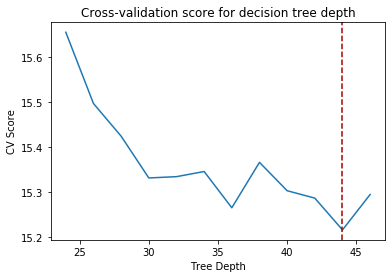

In [15]:
plt.plot(depths, scores)
plt.axvline(x=best_depth, color='#AA0000', linestyle='--')
plt.xlabel('Tree Depth')
plt.ylabel('CV Score')
plt.title('Cross-validation score for decision tree depth')
plt.show()

In [16]:
dec_tree = DecisionTreeRegressor(max_depth=best_depth)
bagger = BaggingRegressor(dec_tree, n_estimators=100)
bagger.fit(x_train_scaled, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=44,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort='deprecated',
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=Tru

In [17]:
accuracy = bagger.score(x_test_scaled, y_test)

print(f'The optimized and scaled tree results in {accuracy:.5f} accurate on the FIFA20 set.')

The optimized and scaled tree results in 0.98668 accurate on the FIFA20 set.


The optimized decision tree regressor resulted in 98.7% accuracy on the FIFA20 data set.

### Try LinearRegression

In [18]:
lr = LinearRegression()
lr.fit(x_train_scaled, y_train)
lr_score = lr.score(x_test_scaled, y_test)

print(f'Checking Linear Regression against test set results in {lr_score:.5f} accurate.')

Checking Linear Regression against test set results in 0.92030 accurate.


A linear regression was performed on the scaled data to do a simple verification that the decision tree regressor was the better choice. This validated this decision as this resulted in 92.6% accuracy. It is also unlikely that regularization would make much more than a small difference as the number are already relatively small.

### Try RandomForest

In [19]:
rfc = RandomForestClassifier(max_depth=90, n_estimators=1000, n_jobs=-1)
rfc.fit(x_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [20]:
rfc_accuracy = rfc.score(x_test_scaled, y_test)

print(f'The random forest results in {rfc_accuracy:.5f} accurate on the FIFA20 set.')

The random forest results in 0.52273 accurate on the FIFA20 set.


The application of RandomForest gave the worst results, but it's not immediately clear why.

## Determining the most important statistics

Since the coefficients are not easily visible on the decision tree, the linear regression will be used to try to identify the most important statistics.

In [21]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in bagger.estimators_
], axis=0)
feature_importances

array([2.11309642e-05, 5.99099763e-04, 4.38183834e-04, 4.98834829e-08,
       4.95096970e-04, 2.76984094e-03, 6.35459784e-03, 8.82917234e-05,
       2.05967114e-02, 3.90471694e-06, 2.85490602e-04, 3.16893776e-04,
       4.36876841e-03, 4.42019315e-04, 4.40523948e-04, 8.21198777e-04,
       7.95282948e-04, 1.54975145e-03, 1.91856266e-05, 5.79183095e-06,
       9.16839691e-06, 8.82164935e-03, 4.06238259e-04, 3.95896432e-04,
       3.36272197e-02, 1.29994642e-03, 1.12086153e-05, 2.33111239e-05,
       2.59227761e-04, 3.45403483e-05, 2.45029559e-05, 4.44245650e-03,
       2.25321663e-05, 6.22996088e-04, 1.17889423e-04, 5.33941776e-04,
       9.73105203e-06, 3.54826204e-03, 8.93941474e-06, 1.97788853e-02,
       1.59965428e-07, 5.23364790e-04, 5.63993956e-05, 3.75785675e-04,
       2.96508352e-02, 3.69869883e-04, 4.84108909e-05, 1.43523135e-05,
       4.54246580e-05, 1.91459505e-05, 9.44447382e-04, 5.48384203e-04,
       3.68432485e-03, 7.85941750e-03, 4.11751053e-04, 7.72422937e-05,
      

In [22]:
coefs = zip(target_cols, feature_importances)
coefs = sorted(coefs, key=lambda x: np.abs(x[1]), reverse=True)
for c in coefs:
    print(f'{c[0]}:{c[1]}')

movement_reactions:0.6741393603302309
cb:0.033627219734062956
rcb:0.029815312611935665
lcb:0.029650835239690122
cf:0.020596711386265964
rf:0.01982199050598916
lf:0.019778885319929676
skill_ball_control:0.01652312064886481
lm:0.01338581378400342
rm:0.01312266640233594
international_reputation:0.012605248112600102
gk_positioning:0.00882164934573286
gk_reflexes:0.008079558889611644
gk_diving:0.007859417499204387
goalkeeping_positioning:0.007807317080321028
goalkeeping_reflexes:0.0069139907033757
goalkeeping_diving:0.006354597839915194
ls:0.004442456503803104
lwb:0.0043687684130545665
rs:0.00431325101365651
st:0.003734343584604122
gk_handling:0.003684324848121409
rwb:0.0035482620435771163
lb:0.002769840935217754
goalkeeping_handling:0.00270056228840202
rb:0.0026931905413554134
mentality_composure:0.0026919928636363576
defending:0.002661972403947846
cam:0.0015497514492899486
cdm:0.0015451124353491766
lam:0.0013383672808008292
ldm:0.0013105915381416758
rw:0.0012999464171427094
rdm:0.00129258

Looking at the average feature importance within the decision trees gives some insight into what predictors are the most important. This will be different for goalkeeper & non-goalkeeper as we know they are driven by different sets of stats with few in common. Firstly, both roles' most important predictor is 'movement_reactions'. This is followed by 'cb' & 'rcb' for non-goalkeepers and 'skill_ball_control' & 'international_reputation' for goalkeepers.

## Reviewing the highest rated players

Any necessary reviewing of the data around the players with the highest overall rating.

In [23]:
pd.set_option('display.max_columns', None)
p19_df[p19_df['overall'] >= 92][['sofifa_id', 'short_name', 'overall', 'defending', 'rdm', 'cdm', 'gk_diving', 'gk_reflexes', 'gk_positioning']]

,sofifa_id,short_name,overall,defending,rdm,cdm,gk_diving,gk_reflexes,gk_positioning
0,20801,Cristiano Ronaldo,94,35.0,61,61,0.0,0.0,0.0
1,158023,L. Messi,94,32.0,61,61,0.0,0.0,0.0
2,190871,Neymar Jr,92,32.0,60,60,0.0,0.0,0.0


In [24]:
pd.set_option('display.max_columns', None)
p20_df[p20_df['overall'] >= 92][['sofifa_id', 'short_name', 'overall', 'defending', 'rdm', 'cdm', 'gk_diving', 'gk_reflexes', 'gk_positioning']]

,sofifa_id,short_name,overall,defending,rdm,cdm,gk_diving,gk_reflexes,gk_positioning
0,158023,L. Messi,94,39.0,66,66,0.0,0.0,0.0
1,20801,Cristiano Ronaldo,93,35.0,61,61,0.0,0.0,0.0
2,190871,Neymar Jr,92,32.0,61,61,0.0,0.0,0.0


## Comparing against older version of the game

This is using the regressor model to understand a high level if the algorithm for determining overall ratings has changed from previous games.

In [25]:
# check against previous games
for file in ['players_15.csv', 'players_16.csv', 'players_17.csv', 'players_18.csv']:
    pold_df = pd.read_csv('cleaned_data/' + file)
    
    xold_test = pold_df[target_cols]
    yold_test = pold_df['overall']
    
    xold_test_scaled = scaler.transform(xold_test)
    
    old_accuracy = bagger.score(xold_test_scaled, yold_test)

    print(f'The accuracy for {file} is {old_accuracy:.5f}.')

The accuracy for players_15.csv is 0.94285.
The accuracy for players_16.csv is 0.94845.


/Users/xylamic/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The accuracy for players_17.csv is 0.96567.


/Users/xylamic/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The accuracy for players_18.csv is 0.96868.


The testing against older files indicates that the scoring mechanism has been very similar starting with FIFA18. Prior to that, it seems a different scoring mechanism was used, and dramatically different in FIFA15.